In [1]:
pip install tensorflow


INFO: pip is looking at multiple versions of tensorflow to determine which version is compatible with other requirements. This could take a while.Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement numpy<=1.24.3,>=1.22 (from tensorflow-intel) (from versions: none)
ERROR: No matching distribution found for numpy<=1.24.3,>=1.22


In [2]:
pip install numpy --upgrade


Note: you may need to restart the kernel to use updated packages.


In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

D:\ANCONDA\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=15

In [5]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE)

Found 2152 files belonging to 3 classes.


In [6]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset)

68

(32, 256, 256, 3)
[0 0 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 1 0 2 1 0 0 1 1 1 2 0]


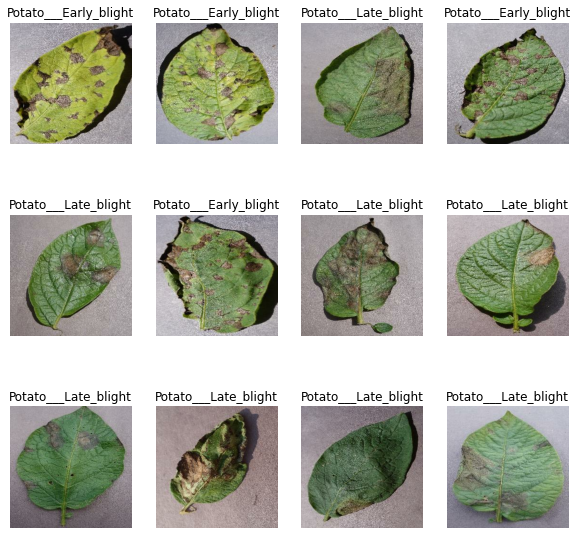

In [8]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
    
    
    
    
    

In [9]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds=dataset.take(54)

In [11]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    val_ds=ds.skip(train_size).skip(val_size)
    
    
    
    
    
    return train_ds,val_ds,test_ds

In [16]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

8

In [19]:
len(test_ds)

8

In [20]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),

    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/15
54/54 [==============================] - 125s 2s/step - loss: 0.9044 - accuracy: 0.5046 - val_loss: 0.8295 - val_accuracy: 0.5430
Epoch 2/15
54/54 [==============================] - 112s 2s/step - loss: 0.6908 - accuracy: 0.6933 - val_loss: 0.6906 - val_accuracy: 0.6602
Epoch 3/15
54/54 [==============================] - 113s 2s/step - loss: 0.4875 - accuracy: 0.7905 - val_loss: 0.4430 - val_accuracy: 0.8320
Epoch 4/15
54/54 [==============================] - 112s 2s/step - loss: 0.4437 - accuracy: 0.8218 - val_loss: 0.3681 - val_accuracy: 0.8359
Epoch 5/15
54/54 [==============================] - 120s 2s/step - loss: 0.3262 - accuracy: 0.8692 - val_loss: 0.4303 - val_accuracy: 0.8516
Epoch 6/15
54/54 [==============================] - 148s 3s/step - loss: 0.2488 - accuracy: 0.9034 - val_loss: 0.1391 - val_accuracy: 0.9492
Epoch 7/15
54/54 [==============================] - 121s 2s/step - loss: 0.2183 - accuracy: 0.9080 - val_loss: 0.1183 - val_accuracy: 0.9609
Epoch 8/15
54

In [27]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 12s 528ms/step - loss: 0.1156 - accuracy: 0.9569


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
history.history['accuracy']

[0.5046296119689941,
 0.6932870149612427,
 0.7905092835426331,
 0.8217592835426331,
 0.8692129850387573,
 0.9033564925193787,
 0.9079861044883728,
 0.9236111044883728,
 0.9513888955116272,
 0.9589120149612427,
 0.9652777910232544,
 0.9589120149612427,
 0.9722222089767456,
 0.9768518805503845,
 0.9849537014961243]

In [32]:
history.history['loss']

[0.9044051170349121,
 0.6908136010169983,
 0.48752063512802124,
 0.443728506565094,
 0.3262493312358856,
 0.2487713247537613,
 0.2182941436767578,
 0.2044118195772171,
 0.12012016028165817,
 0.09629552811384201,
 0.09794540703296661,
 0.11138898134231567,
 0.06794563680887222,
 0.055692944675683975,
 0.0385698638856411]

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

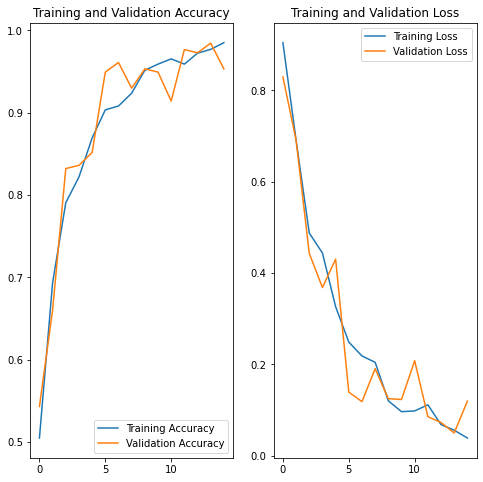

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Late_blight


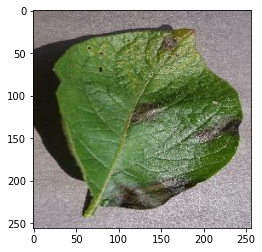

In [35]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [36]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 94ms/step


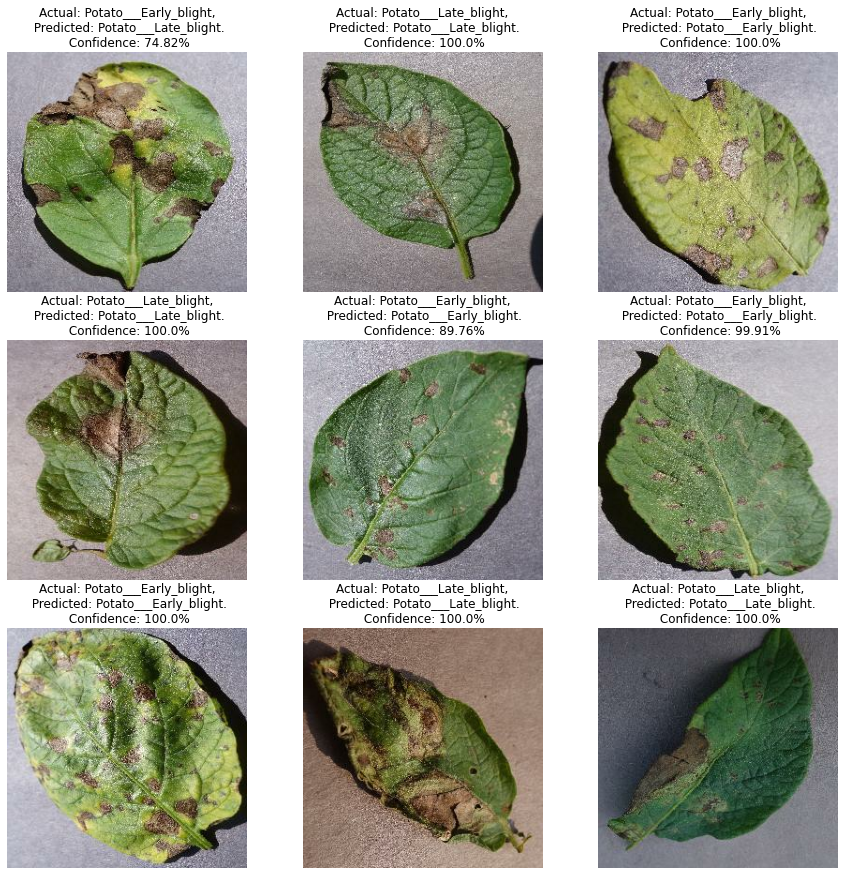

In [37]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [39]:
import os
model_version = max([int(i) for i in (os.listdir("../model")+[0])]) + 1
model.save(f"../model/{model_version}")


INFO:tensorflow:Assets written to: ../model/2\assets


INFO:tensorflow:Assets written to: ../model/2\assets
